In [65]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import copy
import torch
from sklearn.metrics import r2_score
import torch.optim as optim
import torch.nn as nn
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from computational import dataset, get_element, indexNumber, EleEncoder
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
import time

def setup_seed(seed):
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    return seed
randomseed = setup_seed(9807)


#  Architecture with convolutional layer



In [66]:


class Combine_ipt(tf.keras.layers.Layer):
    def __init__(self):
        super(Combine_ipt, self).__init__()

    def call(self, inputs):
        ipt1 = inputs[0]
        ipt2 = inputs[1]
        res = tf.concat([ipt1, ipt2], -1)

        return res


def DNN_mix(input1, input2, output):
    ipt1 = Input((input1.shape[1], 1))
    cov1 = Conv1D(filters=2, kernel_size=2, activation="tanh")(ipt1)
    max1 = MaxPool1D()(cov1)
    # cov2=Conv1D(filters=2, kernel_size=2,activation="tanh")(max1)
    # max2=MaxPool1D()(cov2)
    f = Flatten()(max1)
    f1 = Dense(20, activation="relu")(f)

    ipt2 = Input((input2.shape[1]))
    bp1 = Dense(10, activation="relu")(ipt2)
    bp2 = Dense(20, activation="relu")(bp1)
    # bp3=Dense(10,activation="relu")(bp2)

    ci = Combine_ipt()([f1, bp2])

    d1 = Dense(30, activation="relu")(ci)
    dp1 = Dropout(0.3)(d1)
    d2 = Dense(50, activation="relu")(dp1)
    dp2 = Dropout(0.3)(d2)
    d3 = Dense(50, activation="relu")(dp2)
    d4 = Dense(50, activation="relu")(d3)

    opt = Dense(output.shape[1], activation="linear")(d4)

    model = Model((ipt1, ipt2), opt)
    model.compile(loss='mse', optimizer='adam', metrics=['acc'])

    return model


def conv_train(input_data_conv_1, input_data_conv_2, Y, datatype, epochs=2000, batch_size=500, verbose=0, i=1):
    X_data_2 = StandardScaler().fit_transform(input_data_conv_2)
    Y_data_conv = StandardScaler().fit_transform(Y)

    X_train_1, X_test_1, Y_train, Y_test = train_test_split(input_data_conv_1,
                                                            Y_data_conv,
                                                            test_size=0.2)
    X_train_2, X_test_2, Y_train, Y_test = train_test_split(X_data_2,
                                                            Y_data_conv,
                                                            test_size=0.2)

    # print(type(X_train_1))
    DNNmodel = DNN_mix(X_train_1, X_train_2, Y_train)
    DNNmodel.fit(x=[X_train_1, X_train_2], y=Y_train,
                 epochs=epochs, batch_size=batch_size, verbose=verbose)

    pred = DNNmodel.predict([X_test_1, X_test_2])
    acc = r2_score(Y_test, pred)
    # plt.figure()
    # plt.scatter(Y_test, pred)
    # plt.title('Accuracy of Convlutional layer mixed DNN of %s is %s' % (datatype, acc))
    plt.subplot(2, 4, i)
    plt.scatter(Y_test, pred)
    plt.xlabel('Test')
    plt.ylabel('Predction')
    plt.title('Accuracy of %s is %.2f' % (datatype, acc))
    return acc


#  Architecture with concentrate

In [67]:
def DNN(X_in, Y_in, train_steps):

    model = nn.Sequential(
        nn.Linear(X_in.shape[1], 30),
        nn.ReLU(),
        nn.Linear(30, 50),
        nn.ReLU(),
        nn.Linear(50, 50),
        nn.ReLU(),
        nn.Linear(50, 20),
        nn.ReLU(),
        nn.Linear(20, Y_in.shape[1])
    )
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    mse_loss = nn.MSELoss()
    
    loss = np.zeros(train_steps, dtype=float)
    acc = np.zeros(train_steps, dtype=float)
    for step in range(train_steps):
        pre = model(X_in)
        mse = mse_loss(pre, Y_in)
        acc_perstep = r2_score(pre.detach().numpy(), Y_in)
        cost = mse
        loss[step] = cost
        acc[step] = acc_perstep
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    return model

def Full_train(input_data_1, input_data_2, Y, datatype, epochs=2000, i=1):
    X_Full = np.concatenate((input_data_1, input_data_2), axis=1)
    Y_data_Full = StandardScaler().fit_transform(Y)
    X_train, X_test, Y_train, Y_test = train_test_split(StandardScaler().fit_transform(X_Full),
                                                        StandardScaler().fit_transform(Y_data_Full),
                                                        test_size=0.2)

    torchX_train = torch.tensor(X_train, dtype=torch.float)
    torchX_test = torch.tensor(X_test, dtype=torch.float)
    torchY_train = torch.tensor(Y_train, dtype=torch.float)
    torchY_test = torch.tensor(Y_test, dtype=torch.float)

    DNNmodel = DNN(torchX_train , torchY_train, epochs)

    pred = DNNmodel(torchX_test)

    acc = r2_score(Y_test, pred.detach().numpy())
    plt.subplot(2, 4, i)
    plt.scatter(Y_test, pred.detach().numpy())
    plt.xlabel('Test')
    plt.ylabel('Predction')
    plt.title('Accuracy of %s is %.2f' % (datatype, acc))
    return acc


# Generate Data


In [68]:
def dataset(valuetype='modulus', index=1, Encoder='EleEncoder'):

    if valuetype != 'modulus':
        cubic = True
    else:
        cubic = False
        
    load_dict = np.load('originaldata_file.npy', allow_pickle=True).item()
    load_dict_copy = copy.deepcopy(load_dict)
    for i in load_dict_copy.keys():
        if len(get_element(i)) > 4:
            del load_dict[i]

    symbol = []
    hall = []
    for i in range(1):
        point_group = []
        pretty_formula_encode = []
        wrongcomp = []
        crystal_system = []
        oxide_type = []
        Bulk_modulus = []
        Shear_modulus = []
        for key in load_dict.keys():
            symbol.append(load_dict[key]['spacegroup']['symbol'])
            hall.append(load_dict[key]['spacegroup']['hall'])
            point_group.append(load_dict[key]['spacegroup']['point_group'])
            crystal_system.append(
                load_dict[key]['spacegroup']['crystal_system'])
            if Encoder == 'LabelEncoder':
                pretty_formula_encode.append(load_dict[key]['pretty_formula'])
            elif Encoder == 'EleEncoder':
                try:
                    pretty_formula_encode.append(EleEncoder(key))
                except:
                    wrongcomp.append(key)

            oxide_type.append(load_dict[key]['oxide_type'])
            Bulk_modulus.append(
                load_dict[key]['elasticity']['G_Voigt_Reuss_Hill'])
            Shear_modulus.append(
                load_dict[key]['elasticity']['K_Voigt_Reuss_Hill'])
    Symbol = np.array(symbol)
    Hall = np.array(hall)
    Point_group = np.array(point_group)
    Pretty_formula_encode = np.array(pretty_formula_encode)
    Crystal_system = np.array(crystal_system)
    Oxide_type = np.array(oxide_type)
    Bulk_modulus = np.array(Bulk_modulus)
    Shear_modulus = np.array(Shear_modulus)

    encoder = LabelEncoder()
    Symbol = encoder.fit_transform(Symbol)
    Hall = encoder.fit_transform(Hall)
    Point_group = encoder.fit_transform(Point_group)
    Crystal_system = encoder.fit_transform(Crystal_system)
    Oxide_type = encoder.fit_transform(Oxide_type)
    Pretty_formula_encode[0]
    # print(Pretty_formula_encode.shape)
    data_0 = []
    count_00 = 0
    for key in load_dict:
        x_0 = [Pretty_formula_encode[count_00],
               load_dict[key]['energy_per_atom'],
               load_dict[key]['volume']/load_dict[key]['nsites'],
               Symbol[count_00],
               Hall[count_00], Point_group[count_00],
               Crystal_system[count_00],
               load_dict[key]['formation_energy_per_atom'],
               load_dict[key]['density'], Oxide_type[count_00],
               load_dict[key]['nsites']]
        count_00 += 1

        if valuetype == 'eigvalues':
            # y_0 = [[load_dict[key]['elasticity']['elastic_tensor'][0][0], load_dict[key]['elasticity']['elastic_tensor'][0][1], 0],
            #        [load_dict[key]['elasticity']['elastic_tensor'][0][1],
            #         load_dict[key]['elasticity']['elastic_tensor'][0][0], 0],
            #        [0, 0, load_dict[key]['elasticity']['elastic_tensor'][3][3]]
            #        ]
            y_0 = load_dict[key]['elasticity']['elastic_tensor']
            # print(y_0)
            if np.linalg.eigvals(y_0)[index+1] <= 1e-6:
                y_0 = [0.]
            else:
                y_0 = [np.linalg.eigvals(y_0)[index+1]]

        elif valuetype == 'realvalues':
            if index == 0:
                # DNN 0.60, RFR 0.57
                if load_dict[key]['elasticity']['elastic_tensor'][0][0] <= 1e-6:
                    y_0 = [0.]
                else:
                    y_0 = [load_dict[key]['elasticity']
                           ['elastic_tensor'][0][0]]
            elif index == 1:
                if load_dict[key]['elasticity']['elastic_tensor'][0][1] <= 1e-6:
                    y_0 = [0.]
                else:
                    y_0 = [load_dict[key]['elasticity']
                           ['elastic_tensor'][0][1]]
            elif index == 2:
                if load_dict[key]['elasticity']['elastic_tensor'][3][3] <= 1e-6:
                    y_0 = [0.]
                else:
                    y_0 = [load_dict[key]['elasticity']
                           ['elastic_tensor'][3][3]]
                # print(valuetype)

        elif valuetype == 'modulus':
            if index == 0:
                if load_dict[key]['elasticity']['G_Voigt_Reuss_Hill'] <= 1e-6:
                    y_0 = [0.]
                else:
                    y_0 = [load_dict[key]['elasticity']['G_Voigt_Reuss_Hill']]
            if index == 1:
                if load_dict[key]['elasticity']['K_Voigt_Reuss_Hill'] <= 1e-6:
                    y_0 = [0.]
                else:
                    y_0 = [load_dict[key]['elasticity']['K_Voigt_Reuss_Hill']]

        data_0.append((x_0, y_0))

    input_1 = []
    input_2 = []
    #xx_0 = []
    yy_0 = []
    input_1 = []
    for i in range(len(data_0)):

        if valuetype != 'modulus':
            if isinstance(data_0[i][1][0], complex) is False and data_0[i][0][5] == 27:
                input_1.append(data_0[i][0][0])
                input_2.append(data_0[i][0][1:])
                # xx_0.append(data_0[i][0])
                yy_0.append(data_0[i][1])

        else:
            if isinstance(data_0[i][1][0], complex) is False:
                input_1.append(data_0[i][0][0])
                input_2.append(data_0[i][0][1:])
                # xx_0.append(data_0[i][0])
                yy_0.append(data_0[i][1])

    input_1 = np.array(input_1, dtype=float)
    input_2 = np.array(input_2)

    # if Encoder == 'EleEncoder':
    #     xx_0 = np.array(xx_0, dtype=np.float64)
    # else:
    #     xx_0 = np.array(xx_0)

    # yy_0 = np.array(yy_0)

    # Remove outliers
    yaxis = []
    for i in range(len(yy_0)):
        yaxis.append(yy_0[i][0])

    std_0 = np.std(yaxis)
    mean_0 = np.mean(yaxis)
    lst_0 = []
    count_0 = 0
    for i in range(len(yaxis)):
        count_0 += 1
        if abs(yaxis[i] - mean_0) > std_0 * 2:
            lst_0.append(i)

    yy_0 = np.delete(yy_0, lst_0, axis=0)
    input_1 = np.delete(input_1, lst_0, axis=0)
    input_2 = np.delete(input_2, lst_0, axis=0)
    if cubic == True:
        input_2 = np.delete(input_2, 4, axis=1)
        input_2 = np.delete(input_2, 4, axis=1)
    #len(data_0[0][0][1:])

    # print(input_1.shape)

    return input_1, input_2, yy_0

In [69]:
input_01, input_02, Y_Bulk = dataset(index=0)
input_11, input_12, Y_Shear = dataset(index=1)

input_21, input_22, Y_eig1 = dataset(index=0, valuetype='eigvalues')
input_31, input_32, Y_eig2 = dataset(index=1, valuetype='eigvalues')
input_41, input_42, Y_eig3 = dataset(index=2, valuetype='eigvalues')

input_51, input_52, Y_c11 = dataset(index=0, valuetype='realvalues')
input_61, input_62, Y_c12 = dataset(index=1, valuetype='realvalues')
input_71, input_72, Y_c44 = dataset(index=2, valuetype='realvalues')

# Conv_DNN

2022-06-07 20:14:47.707418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 20:16:52.401292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 20:16:52.944835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 20:18:54.926166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 20:18:55.487389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 20:19:37.339311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 20:19:37.789996: I tensorflow/core/grappler/optimizers/cust

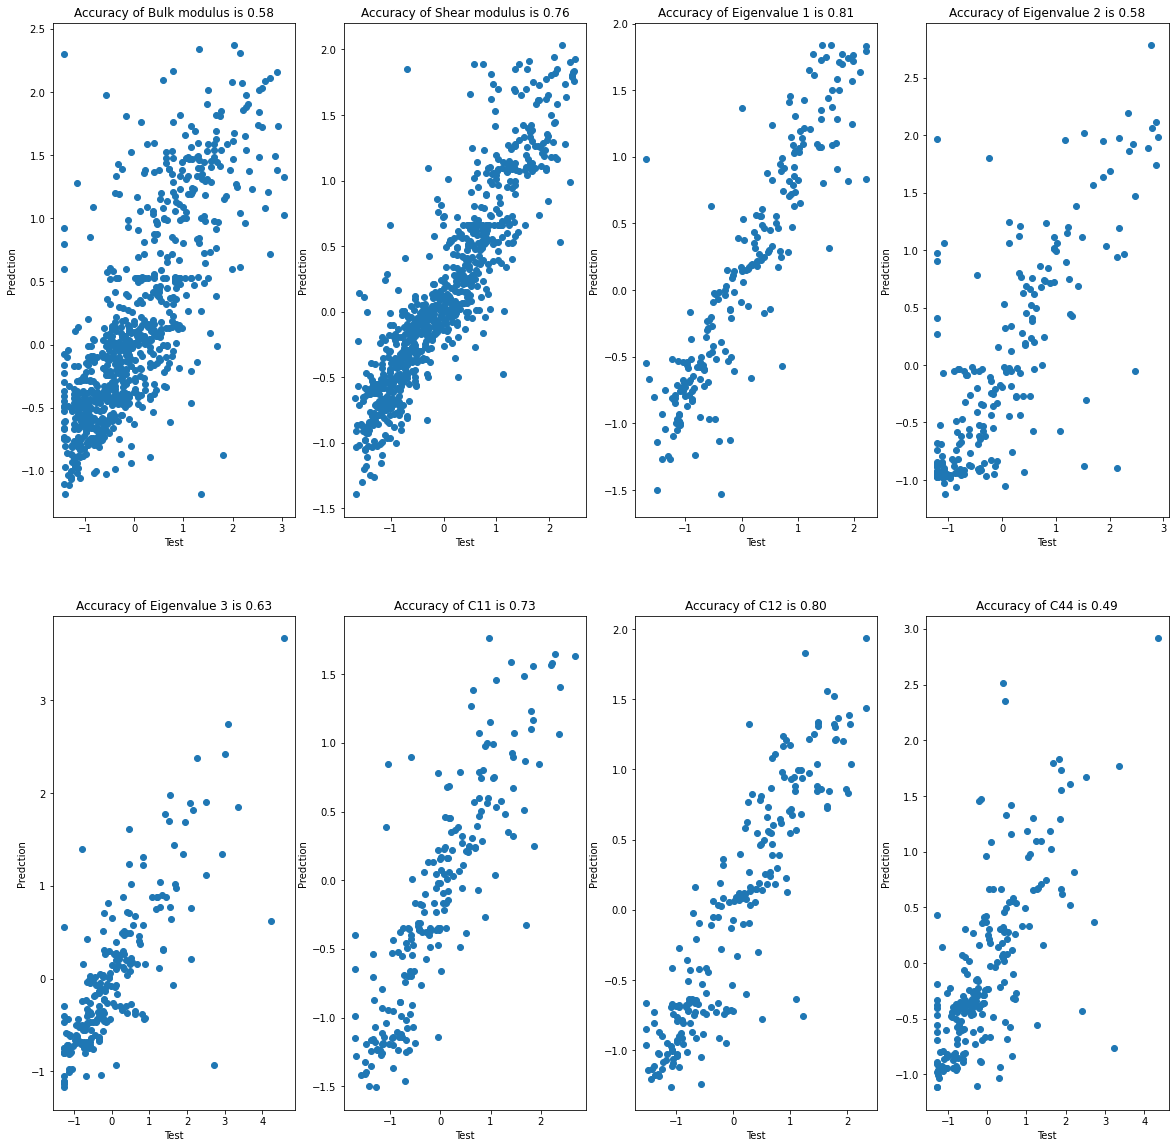

In [73]:
epochs = 2000

plt.figure(figsize=(20, 20))
acc_CD_Bulk = conv_train(input_01, input_02, Y_Bulk,
                                       epochs=epochs, datatype='Bulk modulus', verbose=0, i=1)
# plt.subplot(241)
# plt.scatter(np.linspace(0, len(elite), len(elite)), Elements[_])
# plt.title('Element')
# plt.xlabel('Generations')
# plt.ylabel('Atomic number')


acc_CD_Shear = conv_train(input_11, input_12, Y_Shear,
                          epochs=epochs, datatype='Shear modulus', verbose=0, i=2)


acc_CD_eig1 = conv_train(input_21, input_22, Y_eig1,
                         epochs=epochs, datatype='Eigenvalue 1', verbose=0, i=3)
acc_CD_eig2 = conv_train(input_31, input_32, Y_eig2,
                         epochs=epochs, datatype='Eigenvalue 2', verbose=0, i=4)
acc_CD_eig3 = conv_train(input_41, input_42, Y_eig3,
                         epochs=epochs, datatype='Eigenvalue 3', verbose=0, i=5)

acc_CD_C11 = conv_train(input_51, input_52, Y_c11,
                        epochs=epochs, datatype='C11', verbose=0, i=6)
acc_CD_C12 = conv_train(input_61, input_62, Y_c12,
                        epochs=epochs, datatype='C12', verbose=0, i=7)
acc_CD_C44 = conv_train(input_71, input_72, Y_c44,
                        epochs=epochs, datatype='C44', verbose=0, i=8)


# Full_DNN

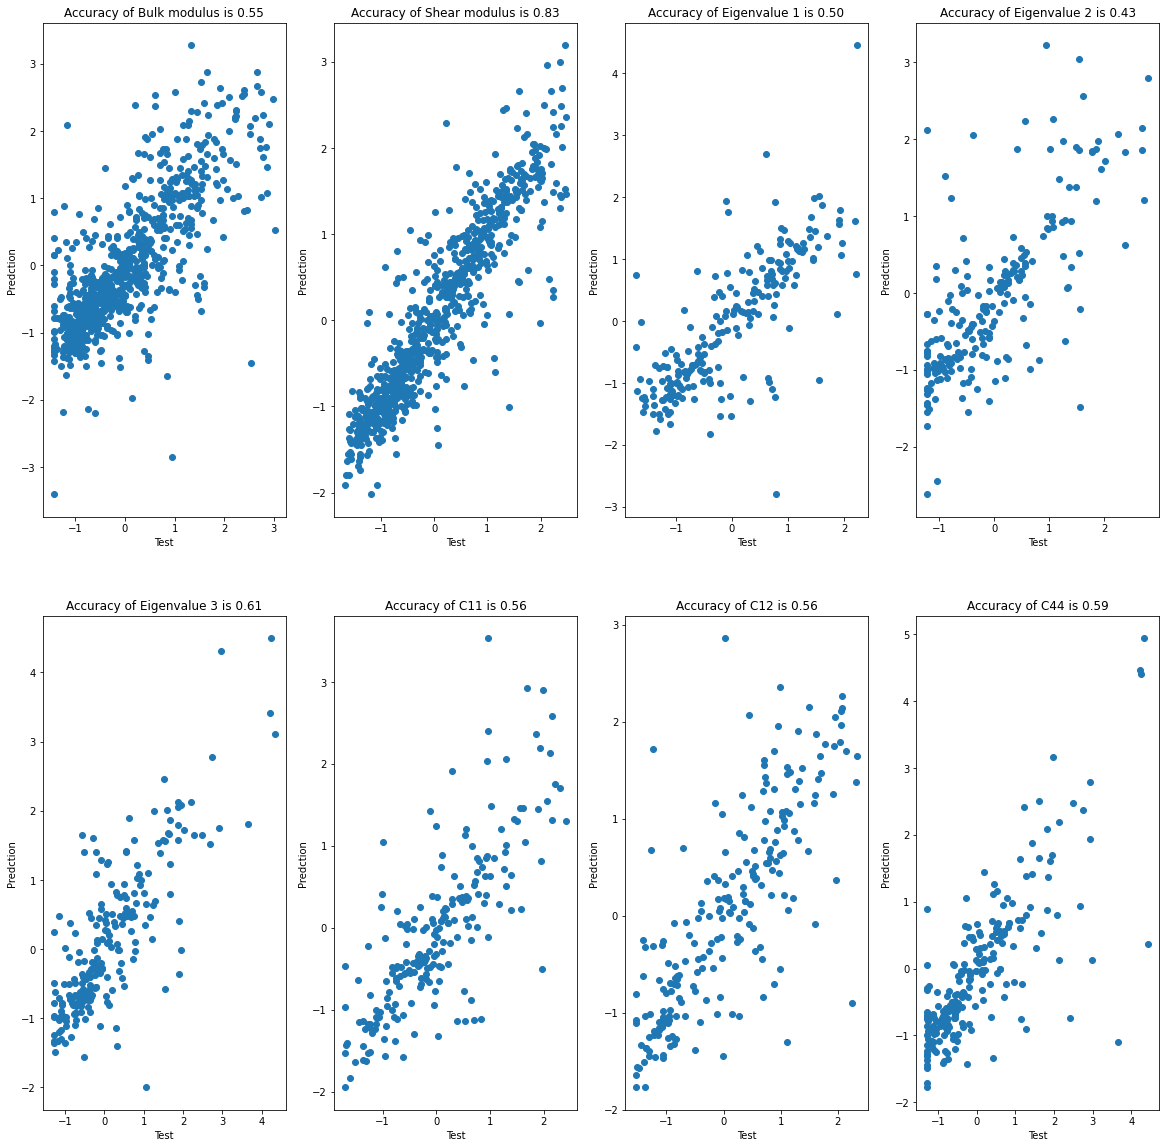

In [74]:
epochs = 2000

plt.figure(figsize=(20, 20))
acc_FD_Bulk = Full_train(input_01, input_02, Y_Bulk,
                         epochs=epochs, datatype='Bulk modulus', i=1)
acc_FD_Shear = Full_train(input_11, input_12, Y_Shear,
                          epochs=epochs, datatype='Shear modulus', i=2)


acc_FD_eig1 = Full_train(input_21, input_22, Y_eig1,
                         epochs=epochs, datatype='Eigenvalue 1', i=3)
acc_FD_eig2 = Full_train(input_31, input_32, Y_eig2,
                         epochs=epochs, datatype='Eigenvalue 2', i=4)
acc_FD_eig3 = Full_train(input_41, input_42, Y_eig3,
                         epochs=epochs, datatype='Eigenvalue 3', i=5)

acc_FD_C11 = Full_train(input_51, input_52, Y_c11,
                        epochs=epochs, datatype='C11', i=6)
acc_FD_C12 = Full_train(input_61, input_62, Y_c12,
                        epochs=epochs, datatype='C12', i=7)
acc_FD_C44 = Full_train(input_71, input_72, Y_c44,
                        epochs=epochs, datatype='C44', i=8)
